# assignment_1b question 0

Question 0 is a self-defined question of choosing the best normalization method for the dataset that we have


# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Starter Code](#starter_code)
* [Data Inspection](#data_inspection)
* [Question 0: Normalization](#normalization)
    * [Normalizing Data](#normalizing_data)
    * [Save and Load Data Objects](#save_and_load_data_objects)
    * [Compare Model Performance](#compare_model_performance)
    * [Comparing Normalization Methods](#comparing_normalization_methods)
* [Conclusion](#conclusion)
* [Saving Data](#saving_data)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Global <a name="global"></a> 
[Back to top](#toc)

In [2]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [3]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename):
    histories_json = {}
    for key in histories.keys():
        histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [4]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

# Starter Code <a name="starter_code"></a>
[Back to top](#toc)

This is the starter code. It is mostly unmodified, except for commenting out imports, and also changing it slightly to accept a different X and Y according to the arguments 

Calling ```starter_code()``` will simply run the original starter_code provided

Calling ```starter_code(X, Y)``` will use the X and Y variables provided as the training data

In [5]:
def starter_code(X, Y):
    NUM_CLASSES = 7

    epochs = 300
    batch_size = 8
    num_neurons = 30
    seed = 10

    histories={}

    np.random.seed(seed)
    tf.random.set_seed(seed)

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X, Y = X[idx], Y[idx]

    # experiment with small datasets
    trainX = X[:100]
    trainY = Y[:100]

    # create a network
    starter_model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu'),
        keras.layers.Dense(1)
    ])

    starter_model.compile(optimizer='sgd',
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])

    # learn the network
    histories['starter'] =starter_model.fit(trainX, trainY,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            verbose = 2)

    # plot learning curves
    plt.plot(histories['starter'].history['mse'], label=' starter model training mse')
    plt.ylabel('mse')
    plt.xlabel('No. epoch')
    plt.legend(loc="lower right")
    plt.show()    
    
    return histories['starter']

# Data Inspection <a name="data_inspection"></a>
[Back to top](#toc)

Before even trying to work with the data, it is a good idea to inspect the data to get a better understanding of the nature and characteristics of what we are working with. We can also take this chance to shape the data according to what we need

In [6]:
df = pd.read_csv("data/admission_predict.csv")
print("df shape: ", df.shape)
print("df columns: ", df.columns)
df.head()

df shape:  (400, 9)
df columns:  Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


From the assignment, <i>Each data sample is a row of 9 values: 1 serial number (ignore), 7 input attributes and the probability of getting an admit as targets. Divide the dataset at 70:30 ratio for training and testing.</i>

In [7]:
df = df.drop("Serial No.", axis=1)
print("df shape: ", df.shape)
df.head()

df shape:  (400, 8)


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


We inspect the variables, and take note of the std, min, max. These will be useful for understanding the need for normalization of data. We should ignore the column Chance of Admit here since it is the class column 

In [8]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


Let's split this into our X and Y data sets first, since the first 7 columns are the training variables and the last column Chance of Admit is the target variable

In [9]:
df_x = df.iloc[:, :-1]
print("df_x shape: ", df_x.shape)
df_x.head()

df_x shape:  (400, 7)


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


Let's take a look at the histogram of the training variables. The histograms will provide some understanding regarding the distributions of the variables. 

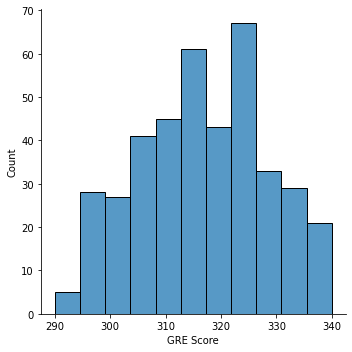

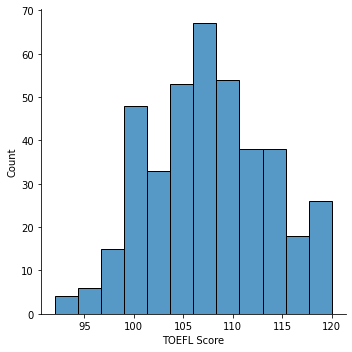

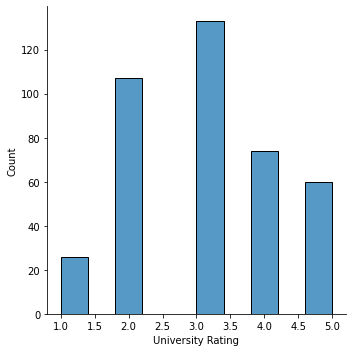

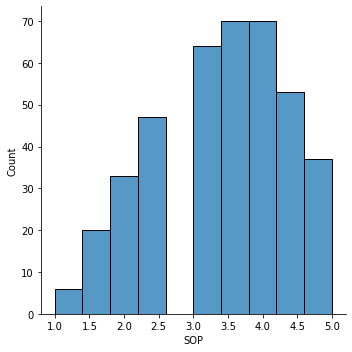

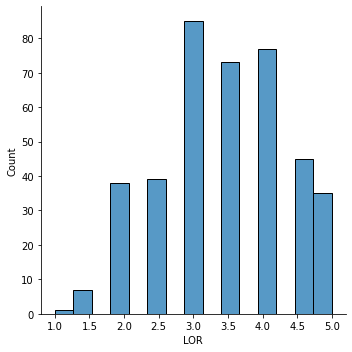

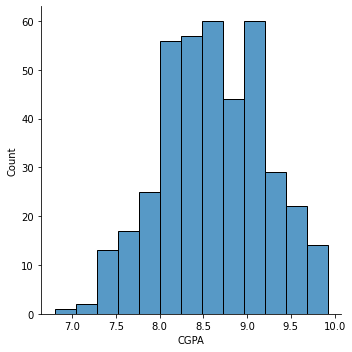

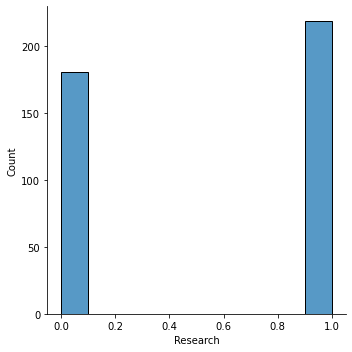

In [10]:
for column in df_x.keys():
    sns.displot(df_x[column])
plt.show()

> We can see that some input features resemble standard normal distributions, some categorical

In [11]:
df_y = df.iloc[:, -1:]
print("df_y shape: ", df_y.shape)
df_y.head()

df_y shape:  (400, 1)


,Chance of Admit
0,0.92
1,0.76
2,0.72
3,0.80
4,0.65


<AxesSubplot:xlabel='Chance of Admit', ylabel='count'>

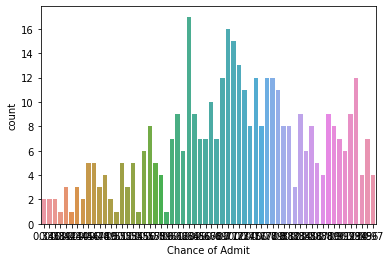

In [12]:
sns.countplot(x="Chance of Admit", data=df_y)

# Qustion 0: Normalization <a name="normalization"></a>
[Back to top](#toc)

There are two simple methods to normalize data
1. Scaling of input features through min-max 
2. Applying standard normal distribution such that data has mean 0, standard deviation 1

The starter code applies a scaling, we shall see if standard normal distribution might be better 

### Normalizing Data <a name="normalizing_data"></a>
[Back to top](#toc)

In [13]:
# scaling
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

df_x_scale = scale(df_x, np.min(df_x, axis=0), np.max(df_x, axis=0))
df_y_scale = df_y

df_x_scale.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,0.94,0.928571,0.75,0.875,0.875,0.913462,1.0
1,0.68,0.535714,0.75,0.750,0.875,0.663462,1.0
2,0.52,0.428571,0.50,0.500,0.625,0.384615,1.0
3,0.64,0.642857,0.50,0.625,0.375,0.599359,1.0
4,0.48,0.392857,0.25,0.250,0.500,0.451923,0.0


In [14]:
# standard normal distribution
def standard(X):
    normalizer = preprocessing.StandardScaler()
    normalized_df = normalizer.fit_transform(X)
    normalized_df = pd.DataFrame(normalized_df, columns=X.columns)
    return normalized_df, normalizer

df_x_standard, df_x_standard_normalizer = standard(df_x)
df_y_standard = df_y

df_x_standard.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,-4.174439e-16,5.595524e-16,7.105427e-17,7.993606e-17,-1.332268e-16,7.771561e-16,-3.996803e-17
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-2.339367e+00,-2.542098e+00,-1.827457e+00,-2.386613e+00,-2.733036e+00,-3.020504e+00,-1.099975e+00
25%,-7.685900e-01,-7.274920e-01,-9.520286e-01,-8.949798e-01,-5.042604e-01,-7.201909e-01,-1.099975e+00
50%,1.679859e-02,-6.763531e-02,-7.660001e-02,9.944220e-02,5.293342e-02,1.859559e-02,9.091117e-01
75%,7.149218e-01,7.571856e-01,7.988286e-01,5.966532e-01,6.101273e-01,7.783704e-01,9.091117e-01
max,2.023903e+00,2.076899e+00,1.674257e+00,1.591075e+00,1.724515e+00,2.218165e+00,9.091117e-01


In [15]:
# Convert to numpy arrays. We now have our normalized data ready
df_x_scale = df_x_scale.to_numpy()
df_y_scale = df_y_scale.to_numpy()
df_x_standard = df_x_standard.to_numpy()
df_y_standard = df_y_standard.to_numpy()

print("converted to numpy array")

converted to numpy array


### Run Starter Model <a name="run_starter_model"></a>
[Back to top](#toc) 

Scaling results - this is the original starter code, unchanged

Epoch 1/300
13/13 - 0s - loss: 0.2227 - mse: 0.2227
Epoch 2/300
13/13 - 0s - loss: 0.0215 - mse: 0.0215
Epoch 3/300
13/13 - 0s - loss: 0.0174 - mse: 0.0174
Epoch 4/300
13/13 - 0s - loss: 0.0164 - mse: 0.0164
Epoch 5/300
13/13 - 0s - loss: 0.0154 - mse: 0.0154
Epoch 6/300
13/13 - 0s - loss: 0.0149 - mse: 0.0149
Epoch 7/300
13/13 - 0s - loss: 0.0142 - mse: 0.0142
Epoch 8/300
13/13 - 0s - loss: 0.0134 - mse: 0.0134
Epoch 9/300
13/13 - 0s - loss: 0.0129 - mse: 0.0129
Epoch 10/300
13/13 - 0s - loss: 0.0125 - mse: 0.0125
Epoch 11/300
13/13 - 0s - loss: 0.0120 - mse: 0.0120
Epoch 12/300
13/13 - 0s - loss: 0.0117 - mse: 0.0117
Epoch 13/300
13/13 - 0s - loss: 0.0114 - mse: 0.0114
Epoch 14/300
13/13 - 0s - loss: 0.0109 - mse: 0.0109
Epoch 15/300
13/13 - 0s - loss: 0.0107 - mse: 0.0107
Epoch 16/300
13/13 - 0s - loss: 0.0107 - mse: 0.0107
Epoch 17/300
13/13 - 0s - loss: 0.0102 - mse: 0.0102
Epoch 18/300
13/13 - 0s - loss: 0.0100 - mse: 0.0100
Epoch 19/300
13/13 - 0s - loss: 0.0098 - mse: 0.0098
Ep

Epoch 155/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 156/300
13/13 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 157/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 158/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 159/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 160/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 161/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 162/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 163/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 164/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 165/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 166/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 167/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 168/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 169/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 170/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 171/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 172/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 173/300
13/13 - 0s - l

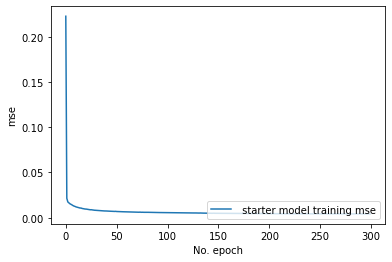

In [16]:
histories['scale'] = starter_code(df_x_scale, df_y_scale)

Normalization results - this uses a normalized input for norm_X

Epoch 1/300
13/13 - 0s - loss: 0.2517 - mse: 0.2517
Epoch 2/300
13/13 - 0s - loss: 0.0955 - mse: 0.0955
Epoch 3/300
13/13 - 0s - loss: 0.0737 - mse: 0.0737
Epoch 4/300
13/13 - 0s - loss: 0.0608 - mse: 0.0608
Epoch 5/300
13/13 - 0s - loss: 0.0525 - mse: 0.0525
Epoch 6/300
13/13 - 0s - loss: 0.0461 - mse: 0.0461
Epoch 7/300
13/13 - 0s - loss: 0.0408 - mse: 0.0408
Epoch 8/300
13/13 - 0s - loss: 0.0372 - mse: 0.0372
Epoch 9/300
13/13 - 0s - loss: 0.0342 - mse: 0.0342
Epoch 10/300
13/13 - 0s - loss: 0.0319 - mse: 0.0319
Epoch 11/300
13/13 - 0s - loss: 0.0298 - mse: 0.0298
Epoch 12/300
13/13 - 0s - loss: 0.0286 - mse: 0.0286
Epoch 13/300
13/13 - 0s - loss: 0.0267 - mse: 0.0267
Epoch 14/300
13/13 - 0s - loss: 0.0254 - mse: 0.0254
Epoch 15/300
13/13 - 0s - loss: 0.0242 - mse: 0.0242
Epoch 16/300
13/13 - 0s - loss: 0.0236 - mse: 0.0236
Epoch 17/300
13/13 - 0s - loss: 0.0226 - mse: 0.0226
Epoch 18/300
13/13 - 0s - loss: 0.0218 - mse: 0.0218
Epoch 19/300
13/13 - 0s - loss: 0.0211 - mse: 0.0211
Ep

Epoch 155/300
13/13 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 156/300
13/13 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 157/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 158/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 159/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 160/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 161/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 162/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 163/300
13/13 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 164/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 165/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 166/300
13/13 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 167/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 168/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 169/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 170/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 171/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 172/300
13/13 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 173/300
13/13 - 0s - l

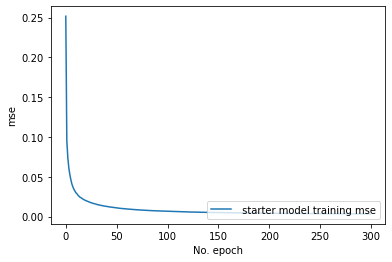

In [17]:
histories['standard'] = starter_code(df_x_standard, df_y_standard)

### Save and Load Data Objects <a name="save_and_load_data_objects"></a> 
[Back to top](#toc)

In [18]:
histories_saver(histories, "data/q0_histories.json")

histories = histories_loader("data/q0_histories.json")

Histories saved
Histories loaded


### Compare Model Performance <a name="compare_model_performance"></a> 
[Back to top](#toc)

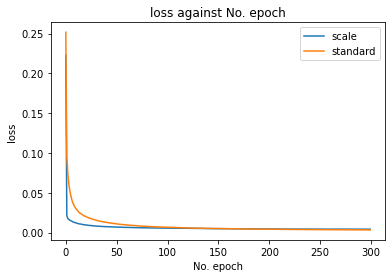

In [19]:
for history_object in ['loss']:
    for model_name in histories.keys():
        plt.plot(histories[model_name][history_object], label=model_name)
    
    plt.title(history_object + ' against No. epoch')
    plt.ylabel(history_object)
    plt.xlabel('No. epoch')
    plt.legend()
    plt.show()

We need to zoom in

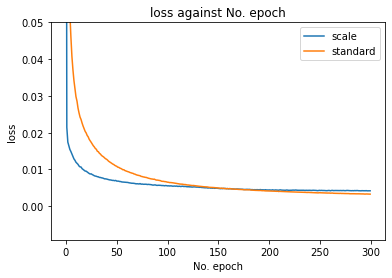

In [20]:
for history_object in ['loss']:
    for model_name in histories.keys():
        plt.plot(histories[model_name][history_object], label=model_name)
    
    plt.ylim(top=0.05)
    plt.title(history_object + ' against No. epoch')
    plt.ylabel(history_object)
    plt.xlabel('No. epoch')
    plt.legend()
    plt.show()

# Conlusion <a name="conclusion"></a>
[Back to top](#toc)

> Use Standard Normal Distribution. It eventually has comparable loss after 100 epochs, and lower loss than Scaling after around 170 epochs

Of course, we didn't emply any train-test split yet but more than likely sufficient to conclude that standard normal distribution works better for this dataset.

However we should note that not all the training variables are likely to follow a standard normal distribution, as we can see from the histogram plots. Some appear to be more discrete

# Saving Data  <a name="saving_data"></a>
[Back to top](#toc)

We are expected to use a 70:30 train-test split for the data that we have, therefore we shall split it right now and use it for all subsequent notebooks, so that we do not have to generate the data again since it is the same data. This will prevent any careless errors as well. 

We should take note that the normalization of the test data should be based on the parameters of the train data, instead of 
1. separately normalizing, which does not show if our model can generalize,
2. grouping test and train data together and normalizing collectively, which pollutes the training weights with test data distributions

In [21]:
# We shall use the same seed as per the starter code
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=seed, shuffle=True)

X_train, X_train_normalizer = standard(X_train)
X_test = X_train_normalizer.transform(X_test) # applying X_train normalization params to X_test
X_test = pd.DataFrame(X_test, columns=X_train.columns)

print("train-test data normalized")

train-test data normalized


In [22]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

np.save('data/X_train', X_train)
np.save('data/X_test', X_test)
np.save('data/Y_train', Y_train)
np.save('data/Y_test', Y_test)
print("All train-test data saved")

All train-test data saved
